# Initial explore of the India Data

In [15]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

In [16]:
from scripts.utils import get_data_path
from src.engineer import Engineer

In [17]:
from src.utils import get_ds_mask

# Open data

In [18]:
data_dir = get_data_path()

In [19]:
e = Engineer(data_dir)
dynamic_ds = e.engineer_class._make_dataset(static=False)
static_ds = e.engineer_class._make_dataset(static=True)

Processing /cats/datastore/data/interim/VCI_preprocessed/data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_1_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_2_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_3_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_4_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/potential_evaporation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/total_precipitation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/2m_temperature_data_india.nc
Processing /cats/datastore/data/interi

In [20]:
mask = get_ds_mask(dynamic_ds['e'])

dynamic_ds['tp'] = dynamic_ds['tp'].where(~mask)
dynamic_ds['VCI'] = dynamic_ds['VCI'].where(~mask)
static_ds['slt'] = static_ds['slt'].where(~mask)

In [21]:
static_ds = static_ds.drop("expver") if "expver" in static_ds.coords else static_ds

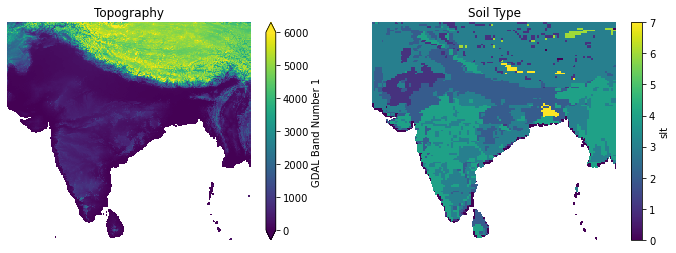

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
kwargs = {"topography": dict(vmin=0, vmax=6000), "slt": dict()}
[static_ds[v].plot(ax=axs[i], **kwargs[v]) for (i, v) in enumerate(static_ds.data_vars)];
axs[0].set_title("Topography")
axs[0].axis('off')
axs[1].set_title("Soil Type")
axs[1].axis('off');

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


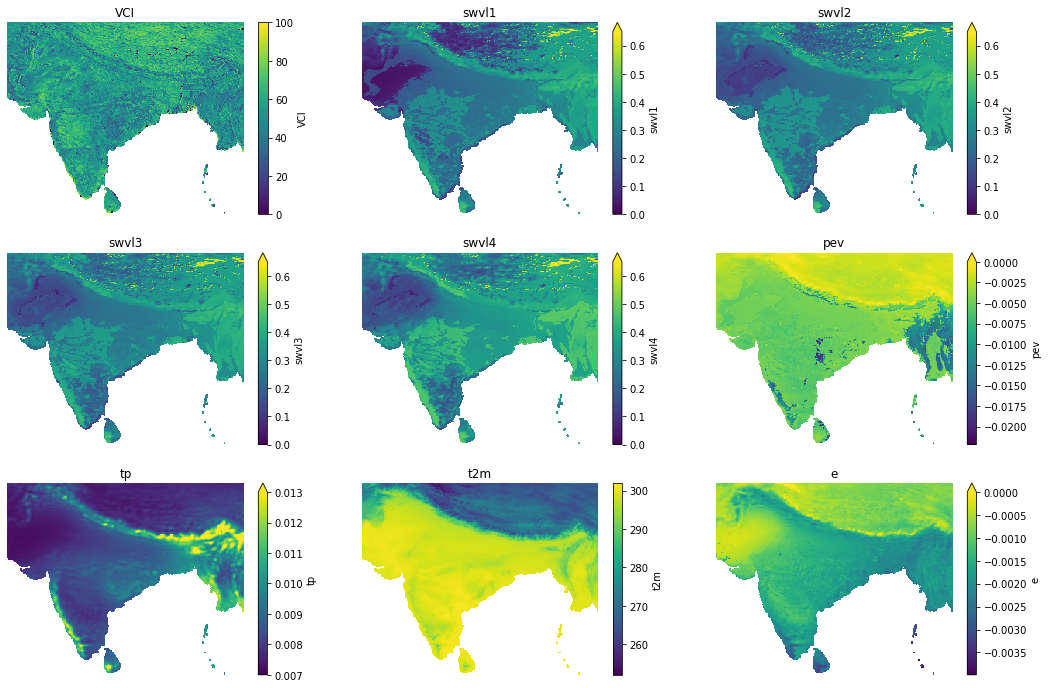

In [23]:
fig, axs = plt.subplots(3,3, figsize=(6*3, 4*3))
kwargs = {
    "VCI": dict(vmin=0, vmax=100), 
    "swvl1": dict(vmin=0, vmax=0.65),
    "swvl2": dict(vmin=0, vmax=0.65),
    "swvl3": dict(vmin=0, vmax=0.65),
    "swvl4": dict(vmin=0, vmax=0.65),
    "tp": dict(vmin=0.007, vmax=0.013),
    "t2m": dict(vmin=None, vmax=None),
    "pev": dict(vmin=None, vmax=0),
    "e": dict(vmin=None, vmax=0),
}

for (i, v) in enumerate(dynamic_ds.data_vars):
    ax = axs[np.unravel_index(i, (3,3))]
    dynamic_ds[v].mean(dim='time').plot(ax=ax, **kwargs[v])
    ax.set_title(v)
    ax.axis('off')

# Open the boundaries ?

In [24]:
[d.name for d in (data_dir / "analysis/boundaries_preprocessed").iterdir()]

['state_l1_india.nc', 'district_l2_india.nc']

In [25]:
district_nc = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")
state_nc = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")

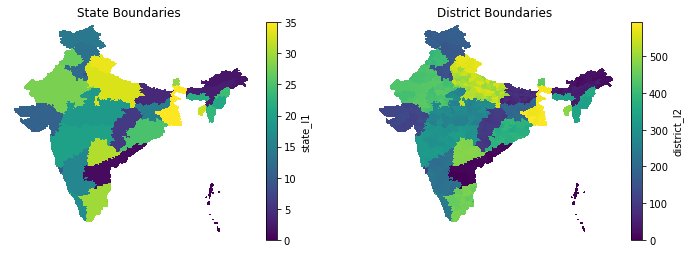

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

state_nc["state_l1"].plot(ax=axs[0])
axs[0].set_title("State Boundaries")
axs[0].axis('off')
district_nc["district_l2"].plot(ax=axs[1])
axs[1].set_title("District Boundaries")
axs[1].axis('off');

# Get forecast data

In [27]:
forecast_paths = [d for d in (data_dir / "interim/s5_preprocessed").iterdir() if "ORIG" in d.name]
forecast_paths

[PosixPath('/cats/datastore/data/interim/s5_preprocessed/s5_erate_india.nc_ORIG'),
 PosixPath('/cats/datastore/data/interim/s5_preprocessed/s5_tprate_india.nc_ORIG'),
 PosixPath('/cats/datastore/data/interim/s5_preprocessed/s5_t2m_india.nc_ORIG')]

In [28]:
s5_data = xr.merge([xr.open_dataset(p) for p in forecast_paths])
s5_data

<xarray.Dataset>
Dimensions:              (forecast_horizon: 195, initialisation_date: 240, lat: 31, lon: 31, number: 51)
Coordinates:
  * initialisation_date  (initialisation_date) datetime64[ns] 2000-01-31 ... 2019-12-31
  * lat                  (lat) float64 35.6 34.6 33.6 32.6 ... 8.6 7.6 6.6 5.6
  * lon                  (lon) float64 67.3 68.3 69.3 70.3 ... 95.3 96.3 97.3
  * forecast_horizon     (forecast_horizon) timedelta64[ns] 29 days ... 92 days
  * number               (number) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
Data variables:
    erate                (initialisation_date, number, forecast_horizon, lat, lon) float32 ...
    tprate               (initialisation_date, number, forecast_horizon, lat, lon) float32 ...
    t2m                  (initialisation_date, number, forecast_horizon, lat, lon) float32 ...

In [30]:
s5_data["forecast_horizon"]

<xarray.DataArray 'forecast_horizon' (forecast_horizon: 195)>
array([2505600000000000, 2592000000000000, 2678400000000000, 5184000000000000,
       5270400000000000, 5356800000000000, 7776000000000000, 7862400000000000,
       7948800000000000, 2419200000000000, 2592000000000000, 2678400000000000,
       5097600000000000, 5270400000000000, 5356800000000000, 7689600000000000,
       7776000000000000, 7862400000000000, 7948800000000000, 2419200000000000,
       2592000000000000, 2678400000000000, 5097600000000000, 5270400000000000,
       5356800000000000, 7689600000000000, 7776000000000000, 7862400000000000,
       7948800000000000, 2419200000000000, 2592000000000000, 2678400000000000,
       5097600000000000, 5270400000000000, 5356800000000000, 7689600000000000,
       7776000000000000, 7862400000000000, 7948800000000000, 2505600000000000,
       2592000000000000, 2678400000000000, 5184000000000000, 5270400000000000,
       5356800000000000, 7776000000000000, 7862400000000000, 7948800000000000,
       2419200000000000, 2592000000000000, 2678400000000000, 5097600000000000,
       5270400000000000, 5356800000000000, 7689600000000000, 7776000000000000,
       7862400000000000, 7948800000000000, 2419200000000000, 2592000000000000,
       2678400000000000, 5097600000000000, 5270400000000000, 5356800000000000,
       7689600000000000, 7776000000000000, 7862400000000000, 7948800000000000,
       2419200000000000, 2592000000000000, 2678400000000000, 5097600000000000,
       5270400000000000, 5356800000000000, 7689600000000000, 7776000000000000,
       7862400000000000, 7948800000000000, 2505600000000000, 2592000000000000,
       2678400000000000, 5184000000000000, 5270400000000000, 5356800000000000,
       7776000000000000, 7862400000000000, 7948800000000000, 2419200000000000,
       2592000000000000, 2678400000000000, 5097600000000000, 5270400000000000,
       5356800000000000, 7689600000000000, 7776000000000000, 7862400000000000,
       7948800000000000, 2419200000000000, 2592000000000000, 2678400000000000,
       5097600000000000, 5270400000000000, 5356800000000000, 7689600000000000,
       7776000000000000, 7862400000000000, 7948800000000000, 2419200000000000,
       2592000000000000, 2678400000000000, 5097600000000000, 5270400000000000,
       5356800000000000, 7689600000000000, 7776000000000000, 7862400000000000,
       7948800000000000, 2505600000000000, 2592000000000000, 2678400000000000,
       5184000000000000, 5270400000000000, 5356800000000000, 7776000000000000,
       7862400000000000, 7948800000000000, 2419200000000000, 2592000000000000,
       2678400000000000, 5097600000000000, 5270400000000000, 5356800000000000,
       7689600000000000, 7776000000000000, 7862400000000000, 7948800000000000,
       2419200000000000, 2592000000000000, 2678400000000000, 5097600000000000,
       5270400000000000, 5356800000000000, 7689600000000000, 7776000000000000,
       7862400000000000, 7948800000000000, 2419200000000000, 2592000000000000,
       2678400000000000, 5097600000000000, 5270400000000000, 5356800000000000,
       7689600000000000, 7776000000000000, 7862400000000000, 7948800000000000,
       2505600000000000, 2592000000000000, 2678400000000000, 5184000000000000,
       5270400000000000, 5356800000000000, 7776000000000000, 7862400000000000,
       7948800000000000, 2419200000000000, 2592000000000000, 2678400000000000,
       5097600000000000, 5270400000000000, 5356800000000000, 7689600000000000,
       7776000000000000, 7862400000000000, 7948800000000000, 2419200000000000,
       2592000000000000, 2678400000000000, 5097600000000000, 5270400000000000,
       5356800000000000, 7689600000000000, 7776000000000000, 7862400000000000,
       7948800000000000, 2419200000000000, 2592000000000000, 2678400000000000,
       5097600000000000, 5270400000000000, 5356800000000000, 7689600000000000,
       7776000000000000, 7862400000000000, 7948800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * forecast_horizon  (forecast_horizon)